# Programming Assignment: Deeper Regression, Smarter Features

Welcome to your first assignment!

You've built a solid foundation in this module, moving from simple linear models to networks that can capture complex, non-linear patterns. Now, it's time to apply those skills to a challenge that mirrors how projects work in a real-world scenario.

So far, you've worked with small, manually created tensors. This time, you'll level up by loading a larger dataset from a `.csv` file, a common first step in any machine learning task. This problem is also more complex: instead of a single input predicting an outcome, you'll have **multiple features** that all work together to influence the final delivery time.

This assignment also introduces you to one of the most creative and impactful parts of machine learning: **feature engineering**. You'll get to write a function that creates a completely new feature from the existing data. Designing features like this is an important skill that allows you to build more powerful and insightful models.

**What You'll Do in This Assignment**

* Prepare the multi-feature dataset using normalization and advanced tensor manipulations.
* Engineer a new feature to capture more complex patterns.
* Build a more sophisticated neural network with multiple hidden layers.
* Train your model on the prepared data.
* Predict a delivery time for a new, unseen order.

Let's get started!

---
<a name='submission'></a>

<h4 style="color:green; font-weight:bold;">TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:</h4>

* All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

* In each exercise cell, look for comments `### START CODE HERE ###` and `### END CODE HERE ###`. These show you where to write the solution code. **Do not add or change any code that is outside these comments**.

* You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

* Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

* To submit your notebook for grading, first save it by clicking the 💾 icon on the top left of the page and then click on the `Submit assignment` button on the top right of the page.
---

## Table of Contents
- [Imports](#0)
- [1 - Multi-Feature Data](#1)
    - [1.1 - Loading and Exploring the Raw Data](#1-1)
    - [1.2 - Feature Engineering: Adding Rush Hour](#1-2)
        - **[Exercise 1 - rush_hour_feature](#ex-1)**
    - [1.3 - Building the Data Preparation Pipeline](#1-3)
        - **[Exercise 2 - prepare_data](#ex-2)**
    - [1.4 - Visualizing the Prepared Data](#1-4)
- [2 - Building the Neural Network](#2)
    - **[Exercise 3 - init_model](#ex-3)**
- [3 - Training the Model](#3)
    - **[Exercise 4 - train_model](#ex-4)**
- [4 - Evaluating Model Performance](#4)
- [5 - Making a New Prediction](#5)

<a name='0'></a>
## Imports

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

In [1]:
import matplotlib.pyplot as plt

import helper_utils
import unittests

<a name='1'></a>
## 1 - Multi-Feature Data

This time, you'll be working with a much richer dataset from a `.csv` file, containing records for **100 past deliveries**. Unlike the previous labs where time depended only on distance, this new problem is more complex. The final delivery time is now influenced by multiple input features.

Here's a breakdown of the data you'll be working with:

* **distance_miles**: The total distance of the delivery route in **miles**, represented as a floating point number.

* **time_of_day_hours**: The time the order was **dispatched for delivery** in **hours** on a 24-hour clock, represented as a floating point number (e.g., `16.07` represents a dispatch time shortly after 4:00 PM).

* **is_weekend**: A binary feature representing the day of the week, where `1` indicates a weekend and `0` indicates a weekday.

* **delivery_time_minutes**: This is your **target variable**. It's the total time the delivery took in minutes, represented as a floating point number.

To make the scenario more realistic, this data operates under a few business rules: **deliveries only occur between 8:00 AM (8.0) and 8:00 PM (20.0), and the company does not deliver further than 20 miles**.

<a name='1-1'></a>
### 1.1 - Loading and Exploring the Raw Data

Load and understand your data. 

* Define the file path to your dataset file, `./data_with_features.csv`.
* Use Pandas library to load the dataset from the given file path as a DataFrame, `data_df`, a powerful structure for manipulating and analyzing data.
* Inspect the shape of your data, which will show as **100 rows** (representing 100 deliveries) and **4 columns**.

In [ ]:
# Load the dataset from the CSV file
file_path = './data_with_features.csv'
data_df = pd.read_csv(file_path)

# Print the shape of the DataFrame
print(f"Dataset Shape: {data_df.shape}\n")

* Inspect the rows of the loaded dataset.
    * By default, `rows_to_display` is set to `10`, but feel free to change this to a different number to explore the data.

In [ ]:
# EDITABLE CELL:

# Set the number of rows you want to display.
rows_to_display = 10

# Display the rows
print(data_df.head(rows_to_display))

<br>

Now that the data is loaded, it is time to visualize it to understand the relationships between your features and what you are trying to predict.

The helper function, `plot_delivery_data` below will create a detailed scatter plot that visualizes all four features at once:

* The **x-axis** will represent the **distance** of the delivery.
* The **y-axis** will represent the **delivery time**.
* The **color** of each point will show the **time of day**, with lighter colors for earlier dispatches and darker reds for later ones.
* The **style** of each point will indicate the day type, with solid circles for weekdays and hollow circles for weekends.

Look for patterns in the plot. Do you see how different features might be influencing the delivery time?

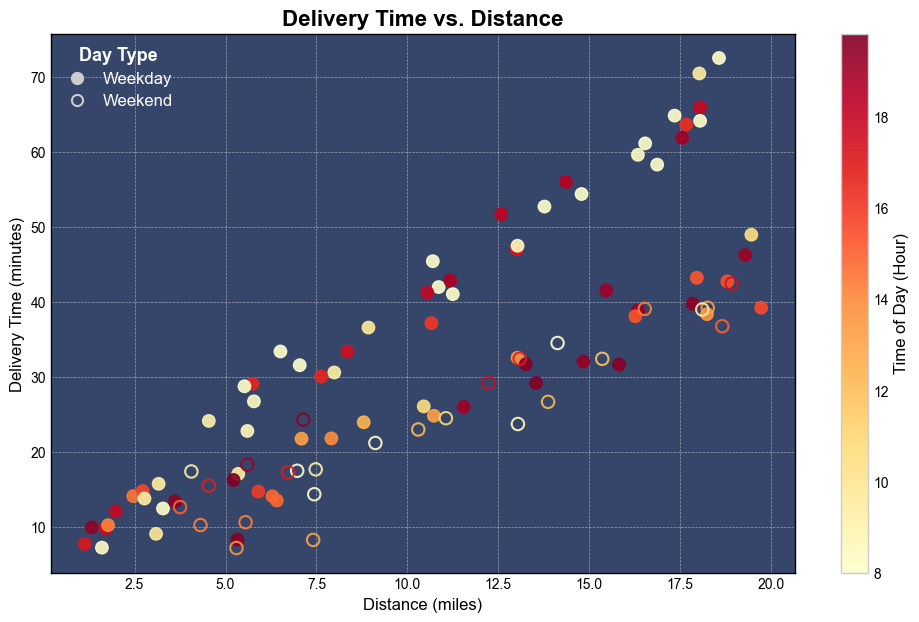

In [5]:
helper_utils.plot_delivery_data(data_df)

<a name='1-2'></a>
### 1.2 - Feature Engineering: Adding Rush Hour

The visualization above reveals an interesting pattern: some deliveries take longer even for the same distance, likely due to peak traffic during **rush hours**.

Instead of hoping the model learns this complex pattern on its own, you can use **feature engineering**. This is a creative step where you apply domain knowledge to make these patterns explicit. You will engineer a new feature that directly tells the model when a delivery falls within a rush hour window.

> This new feature will be `1` if a delivery was dispatched during the morning rush `(8:00 - 10:00 AM)` or the evening rush `(4:00 - 7:00 PM / 16:00 - 19:00)` on a weekday, and `0` otherwise.

Now, you might wonder why rush hour is only being considered on weekdays? This reflects a common real-world pattern. The concept of a "rush hour" is traditionally tied to weekday commuter traffic, which is the pattern that most predictably impacts delivery times on a city-wide scale. This specific pattern disappears on weekends.
Therefore, it's a realistic assumption to make that the primary driver of rush hour delays is the weekday commute.

Before applying logic to the entire dataset, it's a good practice to work with a small sample. This allows you to build and test your function quickly.

* Define the first 5 rows of your `data_df` as a **PyTorch tensor**.
* You use a tensor for this sample because your complete dataset will also be loaded as a tensor. This ensures that the function you build now will work on the full dataset later without any changes.
* This initial tensor contains all the data for each sample delivery.

In [6]:
# Define the 5 rows of data as a single 2D tensor
sample_tensor = torch.tensor([
    # distance, time_of_day, is_weekend, delivery_time
    [1.60,      8.20,        0,          7.22],   # row 1
    [13.09,     16.80,       1,          32.41],  # row 2       
    [6.97,      8.02,        1,          17.47],  # row 3
    [10.66,     16.07,       0,          37.17],  # row 4
    [18.24,     13.47,       0,          38.36]   # row 5
], dtype=torch.float32)

* To create the rush feature, your calculation only depends on the **time of day** and whether it's a **weekday**.
* Use the tensor slicing operation to select only these two columns, ignoring the unnecessary distance and delivery time data for this step.
    * The `time_of_day_hours` is in column index `1`, and `is_weekend` is in column index `2`.

In [7]:
# Use tensor slicing to separate out each column
# Slicing syntax is [:, column_index]
sample_hours = sample_tensor[:, 1]
sample_weekends = sample_tensor[:, 2]

print("--- Sliced Tensors ---")
print(f"Sample Hours:    {sample_hours}")
print(f"Sample Weekends: {sample_weekends}\n")

--- Sliced Tensors ---
Sample Hours:    tensor([ 8.2000, 16.8000,  8.0200, 16.0700, 13.4700])
Sample Weekends: tensor([0., 1., 1., 0., 0.])



<br>

Now that you have the `sample_hours` and `sample_weekends` tensors prepared, you'll use them to build the `rush_hour_feature` function. 

<a name='ex-1'></a>
### Exercise 1 - rush_hour_feature

Implement the `rush_hour_feature` function.

**Your Task:** 

* **Define the individual conditions:**
    * Define `is_morning_rush` to be `True` where the `hours_tensor` is greater than or equal to `8.0` **AND** less than `10.0`.
    * Define `is_evening_rush` to be `True` where the `hours_tensor` is greater than or equal to `16.0` **AND** less than `19.0`.
    * Define `is_weekday` to be `True` where the `weekends_tensor` is equal to `0`.
>
* **Combine the conditions:**
    * Define `is_rush_hour_mask` by combining the three boolean tensors. The logic should be `True` only if it's a weekday **AND** it's either morning rush **OR** evening rush.

**Hint**: You can use standard comparison operators (`>=`, `<`, `==`) and logical operators like `&` (AND) and `|` (OR) directly on PyTorch tensors.

<details>
  <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>
  
If you're stuck, think about how to build each boolean mask step by step.

**For `is_morning_rush`:**
* This requires two comparisons on the `hours_tensor` joined by a logical **AND** (`&`).
* For example, the first part of the condition for the start of the window is `(hours_tensor >= 8.0)`. You'll need to create the second condition (`< 10.0`) and combine them.

**For `is_evening_rush`:**
* Apply the same logic as the morning rush, but for the evening time window.
* For example, the second part of the condition for the end of the window is `(hours_tensor < 19.0)`. You'll need to create the first condition (`>= 16.0`) and combine them.

**For `is_weekday`:**
* This is a single comparison. You need to check which elements in `weekends_tensor` are equal (`==`) to `0`. The logic is: `(weekends equals 0)`.

**For `is_rush_hour_mask`:**
* This step combines the three variables you just made.
* The logic is: `weekday AND (morning rush OR evening rush)`.
* Remember to use parentheses `()` to group the `is_morning_rush` and `is_evening_rush` conditions together with the logical **OR** (`|`) operator.

</details>

In [8]:
# GRADED FUNCTION: rush_hour_feature

def rush_hour_feature(hours_tensor, weekends_tensor):
    """
    Engineers a new binary feature indicating if a delivery is in a weekday rush hour.

    Args:
        hours_tensor (torch.Tensor): A tensor of delivery times of day.
        weekends_tensor (torch.Tensor): A tensor indicating if a delivery is on a weekend.

    Returns:
        torch.Tensor: A tensor of 0s and 1s indicating weekday rush hour.
    """

    ### START CODE HERE ###
    
    # Define rush hour and weekday conditions
    is_morning_rush = (hours_tensor >=8.0) & (hours_tensor <=10.0)
    is_evening_rush =  (hours_tensor >=16.0) & (hours_tensor <=19.0)
    is_weekday = weekends_tensor == 0

    # Combine the conditions to create the final rush hour mask
    is_rush_hour_mask = (is_weekday & (is_morning_rush | is_evening_rush))
    

    ### END CODE HERE ###

    # Convert the boolean mask to a float tensor to use as a numerical feature
    return is_rush_hour_mask.float()

In [9]:
rush_hour_for_sample = rush_hour_feature(sample_hours, sample_weekends)

print(f"Sample Hours:     {sample_hours.numpy()}")
print(f"Sample Weekends:  {sample_weekends.numpy()}")
print(f"Is Rush Hour?:    {rush_hour_for_sample.numpy()}")

Sample Hours:     [ 8.2  16.8   8.02 16.07 13.47]
Sample Weekends:  [0. 1. 1. 0. 0.]
Is Rush Hour?:    [1. 0. 0. 1. 0.]


#### Expected Output

```
Sample Hours:     [ 8.2  16.8   8.02 16.07 13.47]
Sample Weekends:  [0. 1. 1. 0. 0.]
Is Rush Hour?:    [1. 0. 0. 1. 0.]
```

In [10]:
# Test your code!
unittests.exercise_1(rush_hour_feature)

 All tests passed!


<a name='1-3'></a>
### 1.3 - Building the Data Preparation Pipeline

Now that you have your feature engineering function, you'll apply it to the data preparation pipeline. The goal is to create a single function that takes the raw pandas DataFrame as input and outputs the final `features` and `targets` tensors that your model will use for training.

This function will perform several key transformations: it will call your `rush_hour_feature()` function to add the new engineered feature, normalize the `distance_miles` and `time_of_day_hours` columns so they are on a comparable scale, and handle all the necessary tensor operations to structure the data correctly.

This process will yield a single `features` tensor and a single `targets` tensor, perfectly formatted for your neural network.

<a name='ex-2'></a>
### Exercise 2 - prepare_data

**Your Task**:

Your task is to implement the core tensor manipulation steps inside the `prepare_data` function. The code for normalization and combining the final features is already provided.

* **Convert DataFrame to Tensor**:
    * Convert the `all_values` (which are extracted from the pandas DataFrame) into a single PyTorch tensor, `full_tensor`.
    * Remember to set the `dtype` to `torch.float32`.
>    
* **Slice into Raw Tensors**:
    * Use tensor slicing to separate `full_tensor` into individual 1D tensors for each column:
        * `raw_distances` (from column index 0)
        * `raw_hours` (from column index 1)
        * `raw_weekends` (from column index 2)
        * `raw_targets` (from column index 3)
>        
* **Create the Engineered Feature**:
    * Call the `rush_hour_feature()` function you just built.
    * Pass your newly sliced `raw_hours` and `raw_weekends` tensors to it.
>    
* **Reshape Feature Tensors**:
    * Use the `.unsqueeze(1)` method on each of your four feature tensors (`raw_distances`, `raw_hours`, `raw_weekends`, and `is_rush_hour_feature`) to add a new dimension.
 
<details>
  <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>
  
If you need a little help, here's a more detailed guide for each step inside the function.

**For `full_tensor`:**
* You'll use the `torch.tensor()` function here.
* The first argument should be `all_values`, and you should also set the `dtype` to `torch.float32`.

**For slicing into `raw_` tensors:**
* You'll use the slicing syntax `full_tensor[:, index]` for each variable.
* For example, to get the `raw_distances`, the code would be `raw_distances = full_tensor[:, 0]`. Follow this pattern for the other three variables using their respective column indices.

**For `is_rush_hour_feature`:**
* This step is just a function call.
* You need to call `rush_hour_feature()` and pass in the two tensors it needs: `raw_hours` and `raw_weekends`.

**For reshaping feature tensors (e.g., `distances_col`):**
* This is a crucial step for getting your data ready for the model.
* For each of the four feature tensors you have (`raw_distances`, `raw_hours`, etc.), you need to call the `.unsqueeze(1)` method on it.
* For example, the first one would be `distances_col = raw_distances.unsqueeze(1)`.

</details>

In [11]:
# GRADED FUNCTION: prepare_data

def prepare_data(df):
    """
    Converts a pandas DataFrame into prepared PyTorch tensors for modeling.

    Args:
        df (pd.DataFrame): A pandas DataFrame containing the raw delivery data.

    Returns:
        prepared_features (torch.Tensor): The final 2D feature tensor for the model.
        prepared_targets (torch.Tensor): The final 2D target tensor.
        results_dict (dict): A dictionary of intermediate tensors for testing purposes.
    """

    # Extract the data from the DataFrame as a NumPy array
    # (There's no direct torch.from_dataframe(), so we use .values to get a NumPy array first)
    all_values = df.values
    
    ### START CODE HERE ###

    # Convert all the values from the DataFrame into a single PyTorch tensor
    full_tensor = torch.from_numpy(all_values).to(torch.float32)
    
    print(f"full tensor {full_tensor}")
    # Use tensor slicing to separate out each raw column
    raw_distances = full_tensor[:, 0]
    raw_hours = full_tensor[:, 1]
    raw_weekends = full_tensor[:, 2]
    raw_targets = full_tensor[:, 3]

    # Call your rush_hour_feature() function to engineer the new feature
    is_rush_hour_feature = rush_hour_feature(raw_hours, raw_weekends)

    # Use the .unsqueeze(1) method to reshape the four 1D feature tensors into 2D column vectors
    distances_col = raw_distances.unsqueeze(1)
    hours_col = raw_hours.unsqueeze(1)
    weekends_col = raw_weekends.unsqueeze(1)
    rush_hour_col = is_rush_hour_feature.unsqueeze(1)

    ### END CODE HERE ###

    # Normalize the continuous feature columns (distance and time)
    dist_mean, dist_std = distances_col.mean(), distances_col.std()
    hours_mean, hours_std = hours_col.mean(), hours_col.std()
 
    distances_norm = (distances_col - dist_mean) / dist_std
    hours_norm = (hours_col - hours_mean) / hours_std

    # Combine all prepared 2D features into a single tensor
    prepared_features = torch.cat([
        distances_norm,
        hours_norm,
        weekends_col,
        rush_hour_col
    ], dim=1) # dim=1 concatenates them column-wise, stacking features side by side

    # Prepare targets by ensuring they are the correct shape
    prepared_targets = raw_targets.unsqueeze(1)
    
    # Dictionary for Testing Purposes
    results_dict = {
        'full_tensor': full_tensor,
        'raw_distances': raw_distances,
        'raw_hours': raw_hours,
        'raw_weekends': raw_weekends,
        'raw_targets': raw_targets,
        'distances_col': distances_col,
        'hours_col': hours_col,
        'weekends_col': weekends_col,
        'rush_hour_col': rush_hour_col
    }
    

    return prepared_features, prepared_targets, results_dict

In [12]:
# Create a small test DataFrame with the first 5 entries
test_df = data_df.head(5).copy()

# Print the "Before" state as a raw tensor
raw_test_tensor = torch.tensor(test_df.values, dtype=torch.float32)
print("--- Raw Tensor (Before Preparation) ---\n")
print(f"Shape: {raw_test_tensor.shape}")
print("Values:\n", raw_test_tensor)
print("\n" + "="*50 + "\n")

# Run the function to get the prepared "after" tensors
test_features, test_targets, _ = prepare_data(test_df)

# Print the "After" state
print("--- Prepared Tensors (After Preparation) ---")
print("\n--- Prepared Features ---\n")
print(f"Shape: {test_features.shape}")
print("Values:\n", test_features)

print("\n--- Prepared Targets ---")
print(f"Shape: {test_targets.shape}")
print("Values:\n", test_targets)

--- Raw Tensor (Before Preparation) ---

Shape: torch.Size([5, 4])
Values:
 tensor([[ 1.6000,  8.2000,  0.0000,  7.2200],
        [13.0900, 16.8000,  1.0000, 32.4100],
        [ 6.9700,  8.0200,  1.0000, 17.4700],
        [10.6600, 16.0700,  0.0000, 37.1700],
        [18.2400, 13.4700,  0.0000, 38.3600]])


full tensor tensor([[ 1.6000,  8.2000,  0.0000,  7.2200],
        [13.0900, 16.8000,  1.0000, 32.4100],
        [ 6.9700,  8.0200,  1.0000, 17.4700],
        [10.6600, 16.0700,  0.0000, 37.1700],
        [18.2400, 13.4700,  0.0000, 38.3600]])
--- Prepared Tensors (After Preparation) ---

--- Prepared Features ---

Shape: torch.Size([5, 4])
Values:
 tensor([[-1.3562, -1.0254,  0.0000,  1.0000],
        [ 0.4745,  1.0197,  1.0000,  0.0000],
        [-0.5006, -1.0682,  1.0000,  0.0000],
        [ 0.0873,  0.8461,  0.0000,  1.0000],
        [ 1.2951,  0.2278,  0.0000,  0.0000]])

--- Prepared Targets ---
Shape: torch.Size([5, 1])
Values:
 tensor([[ 7.2200],
        [32.4100],
        [1

#### Expected Output

```
--- Prepared Tensors (After Preparation) ---

--- Prepared Features ---

Shape: torch.Size([5, 4])
Values:
 tensor([[-1.3562, -1.0254,  0.0000,  1.0000],
        [ 0.4745,  1.0197,  1.0000,  0.0000],
        [-0.5006, -1.0682,  1.0000,  0.0000],
        [ 0.0873,  0.8461,  0.0000,  1.0000],
        [ 1.2951,  0.2278,  0.0000,  0.0000]])

--- Prepared Targets ---
Shape: torch.Size([5, 1])
Values:
 tensor([[ 7.2200],
        [32.4100],
        [17.4700],
        [37.1700],
        [38.3600]])
```

In [13]:
# Test your code!
unittests.exercise_2(prepare_data)

full tensor tensor([[16.3400,  8.3200,  0.0000, 59.6100],
        [18.0300,  9.4900,  0.0000, 70.4600],
        [ 7.0400,  8.0000,  0.0000, 31.5500],
        [ 3.0900,  9.7000,  0.0000,  9.0600],
        [ 5.3300, 19.5900,  0.0000,  8.2900],
        [ 9.1200,  8.1700,  1.0000, 21.1800],
        [16.5400,  8.0000,  0.0000, 61.1300],
        [17.3500,  8.0000,  0.0000, 64.8400],
        [ 1.1300, 17.1000,  0.0000,  7.7300],
        [10.7000,  8.0000,  0.0000, 45.4200]])
 All tests passed!


<br>

Excellent! As you can see from the sample results above, your `prepare_data` function successfully transformed the raw data into the two distinct tensors your model needs for training.

You started with a `.csv` file containing all the data for each delivery. Your function processed this and produced:

* **A "features" tensor**: This contains the four columns of input data (distance, time of day, weekend flag, rush hour flag) the model will learn from. Notice how the first two columns have been normalized, and the fourth column is your newly engineered `is_rush_hour` feature.

* **A "targets" tensor**: This contains only the final `delivery_time_minutes`, separated from the input features. This is the value your model will learn to predict.

Now that you have verified that your data preparation pipeline works correctly on a small sample, it's time to run it on the entire dataset to prepare all 100 delivery records for training.

In [14]:
# Process the entire DataFrame to get the final feature and target tensors.
features, targets, _ = prepare_data(data_df)

full tensor tensor([[ 1.6000,  8.2000,  0.0000,  7.2200],
        [13.0900, 16.8000,  1.0000, 32.4100],
        [ 6.9700,  8.0200,  1.0000, 17.4700],
        [10.6600, 16.0700,  0.0000, 37.1700],
        [18.2400, 13.4700,  0.0000, 38.3600],
        [ 5.7400, 16.5900,  0.0000, 29.0600],
        [ 8.8000, 12.2500,  0.0000, 23.9400],
        [15.3600, 11.7600,  1.0000, 32.4000],
        [ 5.3500,  9.4200,  0.0000, 17.0600],
        [ 2.4600, 14.4400,  0.0000, 14.0900],
        [ 6.5100,  8.0000,  0.0000, 33.3800],
        [ 4.0600,  9.3300,  1.0000, 17.3800],
        [18.6600, 14.8600,  1.0000, 36.7500],
        [16.3500, 19.0900,  0.0000, 38.8600],
        [13.0300, 13.4200,  0.0000, 32.5500],
        [17.5600, 18.9200,  0.0000, 61.8700],
        [16.2700, 15.2600,  0.0000, 38.0800],
        [ 4.5400,  9.1000,  0.0000, 24.1200],
        [17.9600, 15.2000,  0.0000, 43.2100],
        [11.2500,  8.0000,  0.0000, 41.0300],
        [16.3400,  8.3200,  0.0000, 59.6100],
        [18.0300,  9.4

<a name='1-4'></a>
### 1.4 - Visualizing the Prepared Data

Now that your data preparation pipeline is complete, you can visualize the results to confirm your feature engineering worked as expected.

#### Rush Hour Deliveries Plot

* Run the cell below to display a scatter plot, showing the relationship between `Delivery Time` and `Distance`.
* The points will be colored based on your new feature, making it easy to distinguish between "Rush Hour" and "Not Rush Hour" deliveries.

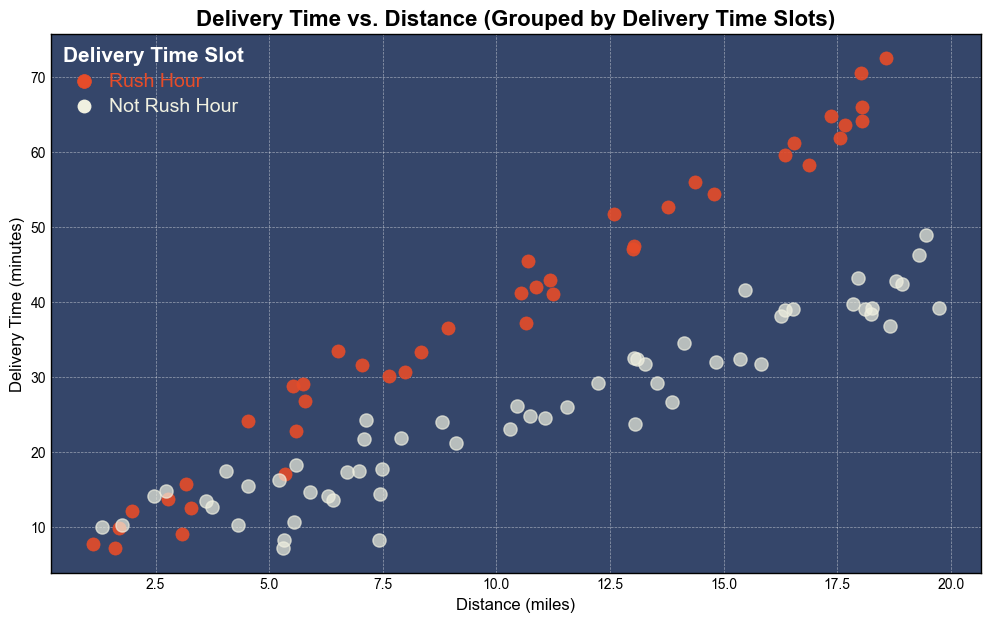

In [15]:
helper_utils.plot_rush_hour(data_df, features)

#### Final Prepared Data Plot

* Run the cell below to display the scatter plot that visualizes the final data you will use for training your model. It will show `Delivery Time` vs. `Normalized Distance`.
* The points are styled by four categories, combining the day type and your new rush hour feature.
* Note that "Weekend (Rush Hour)" does not appear, as your feature correctly applies only to weekdays (as explained above).

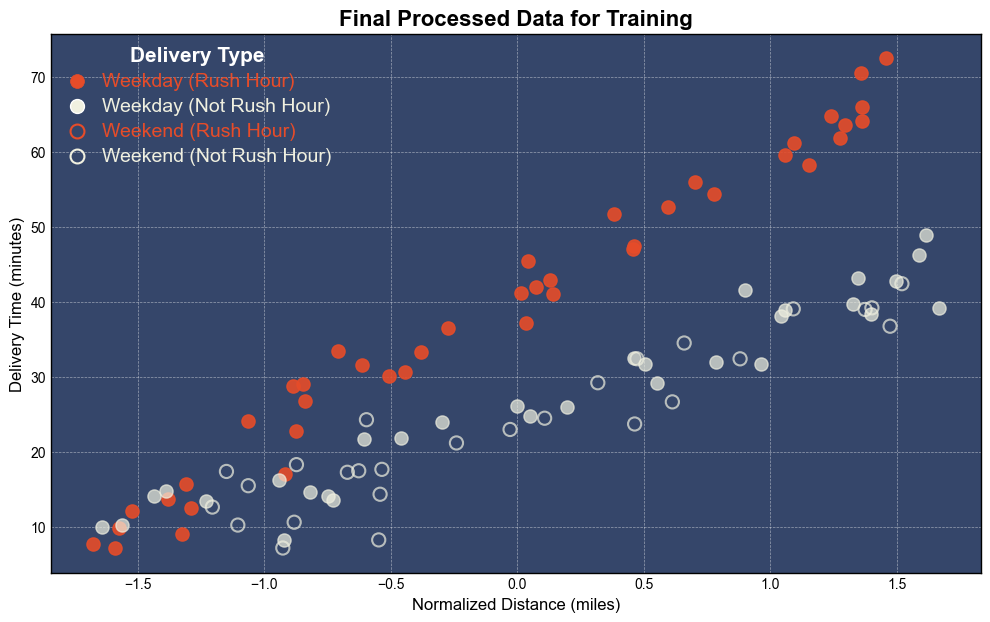

In [16]:
helper_utils.plot_final_data(features, targets)

<a name='2'></a>
## 2 - Building the Neural Network

With your data pipeline complete, you are now ready for the next major stage: **building the model.**

Since your problem now involves multiple features, you'll need a more sophisticated architecture than the ones you had seen before. You will build a neural network with two hidden layers to capture the complex relationships between all your input features.

<a name='ex-3'></a>
### Exercise 3 - init_model

Implement the `init_model` function, to define the model architecture, the optimizer, and the loss function.

**Your Task:**

* **Define the Model Architecture**:
    * Define a `model` using `nn.Sequential`.
    * The model **should only** have three `nn.Linear` layers, each followed by a `nn.ReLU()` activation function, except for the last one.
        * **Input Layer**: An `nn.Linear` layer that accepts **4 input features** and outputs **64 features**.
        * **Hidden Layer**: An `nn.Linear` layer that takes the **64 features** from the previous layer and outputs **32 features**.
        * **Output Layer**: A final `nn.Linear` layer that takes the **32 features** from the hidden layer and produces a **single output** value.
>        
* **Define the Optimizer**:
    * Define the `optimizer` as **Stochastic Gradient Descent (SGD)**. You need to pass it the model's parameters (`model.parameters()`) and set the learning rate (`lr`) to `0.01`.
>
* **Define the Loss Function**:
    * Define the `loss_function` as **Mean Squared Error (MSE)**.
 
<details>
  <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>
  
**For the Model:**
* Remember to list your layers inside the `nn.Sequential()` constructor, separated by commas.
* The `nn.Linear()` layer takes two main arguments: `in_features` and `out_features`. Ensure the `in_features` of one layer matches the `out_features` of the one before it.
* The correct order of layers is: **Input Layer -> ReLU -> Hidden Layer -> ReLU -> Output Layer.**

**For the Optimizer:**
* You will use `optim.SGD`. Its first argument is the model's parameters, which you can get with `model.parameters()`.
* The second argument you need to provide is the learning rate, `lr=0.01`.

**For the Loss Function:**
* You will use `nn.MSELoss`. Since it is a class, you need to create an instance of it by calling it with parentheses: `nn.MSELoss()`.

</details>

In [17]:
# GRADED FUNCTION: init_model

def init_model():
    """
    Initializes the neural network model, optimizer, and loss function.

    Returns:
        model (nn.Sequential): The initialized PyTorch sequential model.
        optimizer (torch.optim.Optimizer): The initialized optimizer for training.
        loss_function: The initialized loss function.
    """

    # Set the random seed for reproducibility of results (DON'T MANIPULATE IT)
    torch.manual_seed(41)

    ### START CODE HERE ###

    # Define the model architecture using nn.Sequential
    model = torch.nn.Sequential(
        # Input layer (Linear): 4 input features, 64 output features
        nn.Linear(4, 64),
        # First ReLU activation function
        nn.ReLU(),
        # Hidden layer (Linear): 64 inputs, 32 outputs
        nn.Linear(64,32),
        # Second ReLU activation function
        nn.ReLU(),
        # Output layer (Linear): 32 inputs, 1 output (the prediction)
        nn.Linear(32,1),
    ) 
    
    # Define the optimizer (Stochastic Gradient Descent)
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Define the loss function (Mean Squared Error for regression)
    loss_function = nn.MSELoss()

    ### END CODE HERE ###

    return model, optimizer, loss_function

In [18]:
model, optimizer, loss_function = init_model()

print(f"{'='*30}\nInitialized Model Architecture\n{'='*30}\n{model}")
print(f"\n{'='*30}\nOptimizer\n{'='*30}\n{optimizer}")
print(f"\n{'='*30}\nLoss Function\n{'='*30}\n{loss_function}")

Initialized Model Architecture
Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

Optimizer
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Loss Function
MSELoss()


#### Expected Output:

```
==============================
Initialized Model Architecture
==============================
Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

==============================
Optimizer
==============================
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

==============================
Loss Function
==============================
MSELoss()
```

In [19]:
# Test your code!
unittests.exercise_3(init_model)

 All tests passed!


<a name='3'></a>
## 3 - Training the Model

With your data prepared and your model architecture defined, it's time for the most important stage: **training**. 

<a name='ex-4'></a>
### Exercise 4 - train_model

Implement the complete training loop inside the `train_model` function.

**Your Task:**

* **Initialize your model and tools:**
    * Start by calling the `init_model()` function you built earlier to get your `model`, `optimizer`, and `loss_function`.
>    
* **Loop through the epochs:**
    * Create a `for` loop that iterates from 0 up to the number of `epochs` provided.
>    
* **Implement the training steps inside the loop:**
    * Perform these five steps **in order** on each iteration:
        * **Forward Pass**: Pass your `features` tensor into the `model` to get its predictions.
        * **Calculate Loss**: Use your `loss_function` to compare the model's predictions with the actual `targets`.
        * **Zero Gradients**: Zero the gradients on the `optimizer` from the previous iteration.
        * **Backward Pass**: Perform the backward pass on your `loss` to calculate the new gradients.
        * **Update Weights**: Take a step with the `optimizer` to update the model's parameters.
 
<details>
  <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>
  
**For Initialization:**
* The `init_model()` function returns three values. You can unpack them directly into your three variables: `model, optimizer, loss_function = init_model()`.

**For the Forward Pass:**
* To get predictions, you can call your `model` object like a "function", passing the `features` as the "argument", `function(argument)`.

**For Calculating Loss:**
* The loss function also works like a function. It takes two arguments, your "predictions" and "actual targets".

**For the Gradient Steps:**
* The three gradient-related steps (`.zero_grad()`, `.backward()`, and `.step()`) are all methods that need to be called with parentheses, for example, `optimizer.zero_grad()`.

</details>

In [20]:
# GRADED FUNCTION: train_model

def train_model(features, targets, epochs, verbose=True):
    """
    Trains the model using the provided data for a number of epochs.
    
    Args:
        features (torch.Tensor): The input features for training.
        targets (torch.Tensor): The target values for training.
        epochs (int): The number of training epochs.
        verbose (bool): If True, prints training progress. Defaults to True.
        
    Returns:
        model (nn.Sequential): The trained model.
        losses (list): A list of loss values recorded every 5000 epochs.
    """
    
    # Initialize a list to store the loss
    losses = []
    
    ### START CODE HERE ###
    
    # Initialize the model, optimizer, and loss function using `init_model`
    model, optimizer, loss_function = init_model()

    # Loop through the specified number of epochs
    for epoch in range(epochs):
        
        # Forward pass: Make predictions
        outputs = model(features)

        # Calculate the loss
        loss = loss_function(outputs, targets)

        # Zero the gradients
        optimizer.zero_grad()

        # Backward pass: Compute gradients
        loss.backward()

        # Update the model's parameters
        optimizer.step()
        
    ### END CODE HERE ### 

        # Every 5000 epochs, record the loss and print the progress
        if (epoch + 1) % 5000 == 0:
            losses.append(loss.item())
            if verbose:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    
    return model, losses

In [23]:
test_model, loss = train_model(features, targets, 10000)

Epoch [5000/10000], Loss: 4.3202
Epoch [10000/10000], Loss: 1.7398


#### Expected Output (approximately):

```
Epoch [5000/10000], Loss: 3.0901
Epoch [10000/10000], Loss: 1.6064
```

In [24]:
# Test your code!
unittests.exercise_4(train_model, features, targets)

 All tests passed!


---
# Submission Note

Congratulations! You've completed the final graded exercise of this assignment.

If you've successfully passed all the unit tests above, you've completed the core requirements of this assignment. Feel free to [submit](#submission) your work now. The grading process runs in the background, so it will not disrupt your progress and you can continue on with the rest of the material.

**🚨 IMPORTANT NOTE** If you have passed all tests within the notebook, but the autograder shows a system error after you submit your work:

<div style="background-color: #1C1C1E; border: 1px solid #444444; color: #FFFFFF; padding: 15px; border-radius: 5px;">
    <p><strong>Grader Error: Grader feedback not found</strong></p>
    <p>Autograder failed to produce the feedback...</p>
</div>
<br>

This is typically a temporary system glitch. The most common solution is to resubmit your assignment, as this often resolves the problem. Occasionally, it may be necessary to resubmit more than once. 
>
If the error persists, please reach out for support in the [DeepLearning.AI Community Forum](https://community.deeplearning.ai/c/course-q-a/pytorch-for-developers/pytorch-fundamentals/560).

---

<br>

It's time to put your `train_model` function to work. Run the complete training on the `features` and `targets`. You will train the model for `30,000` epochs (more than the test run to ensure full convergence on the complete dataset), which gives it ample opportunity to learn the patterns in the data.

In [28]:
# Training loop
model, loss = train_model(features, targets, 30000)

Epoch [5000/30000], Loss: 4.3202
Epoch [10000/30000], Loss: 1.7398
Epoch [15000/30000], Loss: 1.0605
Epoch [20000/30000], Loss: 0.8506
Epoch [25000/30000], Loss: 0.9309
Epoch [30000/30000], Loss: 0.4355


<a name='4'></a>
## 4 - Evaluating Model Performance

Now that your model is trained, it's time to evaluate its performance. A simple yet powerful way to do this for a regression task is to plot the model's predictions against the actual target values.

* First, use your trained `model` to get predictions for the entire dataset.
* Then, create a scatter plot, **Actual Delivery Times (x-axis) vs. Predicted Delivery Times (y-axis)**.
* If the model is accurate, the points on the plot should form a tight cluster along a straight diagonal line.
    * The closer the points are to this line, the better your model's predictions are.
    
Let's see how well your model did!

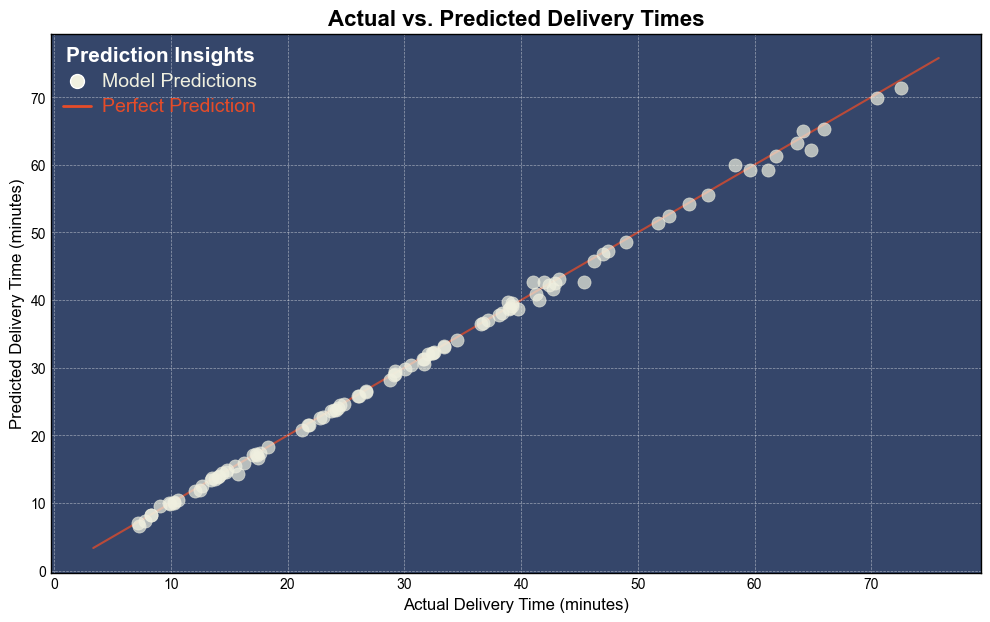

In [29]:
# Disable gradient calculation for efficient predictions
with torch.no_grad():
    # Perform a forward pass to get model predictions
    predicted_outputs = model(features)

# Plot predictions vs. actual targets to evaluate performance
helper_utils.plot_model_predictions(predicted_outputs, targets)

<br>

The results look fantastic!

As you can see in the "Actual vs. Predicted" plot, the model's predictions (the light gray points) form a very tight cluster that follows the "Perfect Prediction" line almost exactly. This indicates that your model has learned the patterns in the data very well and is making highly accurate predictions.

A result like this in a real-world project would be considered a great success. With your model's performance evaluated, you're ready for the final step: using it to make a prediction on new, unseen data.

<a name='5'></a>
## 5 - Making a New Prediction

With a well-trained and evaluated model, you've reached the final and most practical stage: **prediction**. It's time to use your model to make a prediction on new, unseen data. 

* Define a new delivery scenario by setting the distance, time of day, and whether it's a weekend.

**Note on Business Rules:**
Remember the constraints of the delivery service when setting your values:
* **Distance**: Must be less than or equal to `20` miles.
* **Time**: Must be between `8.0` (8:00 AM) and `20.0` (8:00 PM).
* **Weekend**: Can be set using `True`/`False` or `1`/`0`.

In [30]:
# EDITABLE CELL: Set your values below

# Change the values below to get an estimate for a different delivery
# Set distance for the delivery in miles
distance_miles = 17
# Set time of day in 24-hour format (e.g., 9.5 for 9:30 AM)
time_of_day_hours = 10.5
# Use True/False or 1/0 to indicate if it's a weekend
is_weekend = 0

# Convert the raw inputs into a 2D tensor for the model
raw_input_tensor = torch.tensor([[distance_miles, time_of_day_hours, is_weekend]], dtype=torch.float32)

Now, you'll pass your trained `model`, the original `data_df`, your `raw_input_tensor`, and the `rush_hour_feature` function to the helper function. This will process your new inputs and use the model to generate the estimated delivery time.

In [31]:
helper_utils.prediction(model, data_df, raw_input_tensor, rush_hour_feature)

+------------------------------------------+-----------------------+
|                         Model Prediction                         |
+------------------------------------------+-----------------------+
| Time of the Week                         | Weekday               |
| Distance                                 | 17.0 miles            |
| Time                                     | 10:30                 |
| Is this considered a rush hour period?   | No                    |
+------------------------------------------+-----------------------+
| Estimated Delivery Time                  | 30.75 minutes         |
+------------------------------------------+-----------------------+


## Conclusion

Congratulations on completing your first assignment!

You have successfully navigated every key stage of the pipeline. You started with raw data from a `.csv` file, performed **feature engineering** to add business logic to your dataset, and built a complete **data preparation pipeline** to automate the process.

From there, you designed and **trained** a multi-layer neural network, moving beyond the simple models of the ungraded labs. You then **evaluated** its performance by visualizing its predictions and, finally, used your trained model to make a **prediction** on new, unseen data.

The skills you've practiced here on manipulating tensors, designing features, and building end-to-end training pipelines are the fundamental building blocks for tackling even more complex challenges in deep learning. You now have a solid foundation to build upon as you move forward. Well done!